In [289]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Coding Handbook for Basic Classifiers

This notebooks means to be a starter code for basic training of classifiers.

1.  Training basic models.
2. Plots useful visuals and metrics to understand the features.
3. Use searching engines to tune the parameters.

The goal is to create a consistent and concise coding flow for the easiness of future implementation.

## Preprocessing

1. To turn the categorical column into the dummies, we do not adopt the `get_dummies` function from `pandas`, instead use `OneHotEncode` from `sklearn`. The `drop=if_binary` parameter will only keep one dummy column for features that only contain two classes.
2. Before encoding the data, the code drops the continuous features first and then add them back using `concat`.

In [6]:
marketing = pd.read_csv("marketing.csv")
marketing_categorical = marketing.drop(["balance", "age"], axis=1)
ohe = OneHotEncoder(drop="if_binary", sparse=False)
marketing_encoded = pd.DataFrame(ohe.fit_transform(marketing_categorical))

# Fix index
marketing_encoded.index = marketing.index
# Fix column names
marketing_encoded.columns = ohe.get_feature_names_out(marketing_categorical.columns)
marketing_encoded = pd.concat(
    [marketing_encoded, marketing[["age", "balance"]]], axis=1
)

# Now we can split our sample.
X_train, X_test, y_train, y_test = train_test_split(
    marketing_encoded.drop(columns=["y_yes"]),
    marketing_encoded["y_yes"].astype(int),
    test_size=0.33,
    random_state=1,
)

Note that this dataset is **imbalanced**.

In [135]:
y_train.value_counts(normalize=True)

0    0.882176
1    0.117824
Name: y_yes, dtype: float64

## Simple Models

Here, we fit several basic models for illustration purposes. Their parameters are not calibrated.

In [290]:
# Fit Logistic Regression
from sklearn.linear_model import LassoCV, LogisticRegression
logistic_reg = LogisticRegression(penalty="none", max_iter=10000)
logistic_reg.fit(X_train, y_train)
pred_test_logistic = logistic_reg.predict(X_test)

In [291]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500, oob_score = True)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, oob_score=True)

In [292]:
prob_test_logistic = logistic_reg.predict_proba(X_test)[:,1]
prob_test_rf = rf.predict_proba(X_test)[:,1]

**Random Forest with Larger min_samples_leaf**

For imbalanced dataset, it is important to control the minmimum samples for each leaf to contain enough positive data points in the learning process.

In [297]:
rf2 = RandomForestClassifier(n_estimators=500, oob_score=True, min_samples_leaf=20)
rf2.fit(X_train, y_train)
prob_test_rf2 = rf2.predict_proba(X_test)[:, 1]

**XGBoosting**

Add a validation set to decide the early stopping (tuning the number of trees for boosting). We don't have a separate validation set from the test set, so here we are being careless.

In [298]:
xgb_model = XGBClassifier(
    n_estimators=1000, random_state=1, learning_rate=0.3, max_depth=6, use_label_encoder=False
).fit(
    X_train,
    y_train,
    early_stopping_rounds=50,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    verbose=False,
)

In [299]:
prob_test_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [300]:
print(xgb_model.best_iteration)
print(xgb_model.best_score)

54
0.698468


## Evaluation

### ROC Curve

In [212]:
def roc_plot(y_test, y_pred_score, model_label="", ax=None):
    """
    Plot the roc curve given true values and predicted scores.
    If plot on top of the main plot, need to send the ax to this function.
    """
    fpr, tpr, threshold = roc_curve(y_test, y_pred_score)
    auc = metrics.auc(fpr, tpr)
    if ax == None:
        # Ploting
        plt.style.use("ggplot")
        # plt.style.use("fivethirtyeight")
        # plt.style.use("seaborn-talk")
        # plt.style.use("seaborn-bright")
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, label=model_label + " - AUC: {:.2f}".format(auc))
        ax.plot([0, 1], [0, 1], "k--")
        ax.set(
            xlabel="False Positive Rate (FPR)",
            ylabel="True Positive Rate (TPR)",
            title="ROC curve",
        )
        ax.legend(loc="lower right")
        return ax
    else:
        ax.plot(fpr, tpr, label=model_label + " - AUC: {:.2f}".format(auc))
        ax.legend(loc="lower right")

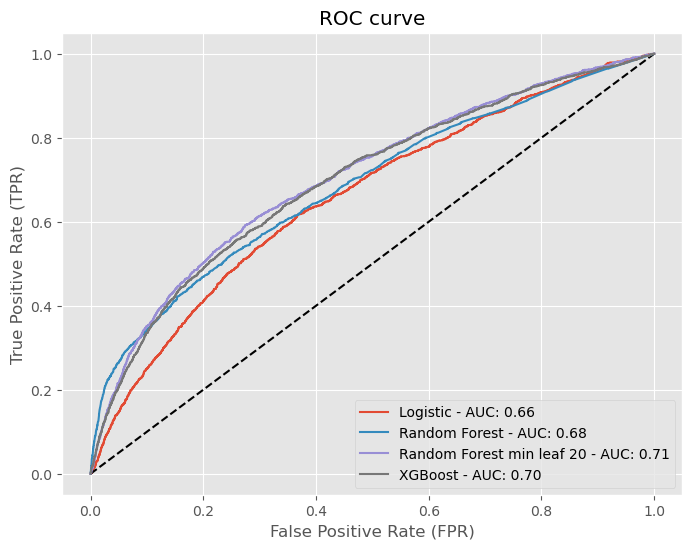

In [245]:
ax = roc_plot(y_test, prob_test_logistic, "Logistic")
roc_plot(y_test, prob_test_rf, "Random Forest", ax)
roc_plot(y_test, prob_test_rf2, "Random Forest min leaf 20", ax)
roc_plot(y_test, prob_test_xgb, "XGBoost", ax)

### Confusion Matrix

In [132]:
def confusion_matrix_plot(y_test, y_pred, plot=True, prob=False, p=0.5):
    """
    Plot the confusion matrix.
    """
    import seaborn as sns
    import matplotlib
    from matplotlib import pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
    # For best visualizations, need to use default style
    # matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    if prob:
        y_pred = np.where(y_pred > 0.5, 1, 0)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    if plot:
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False)
        plt.show()

Accuracy: 88.46%


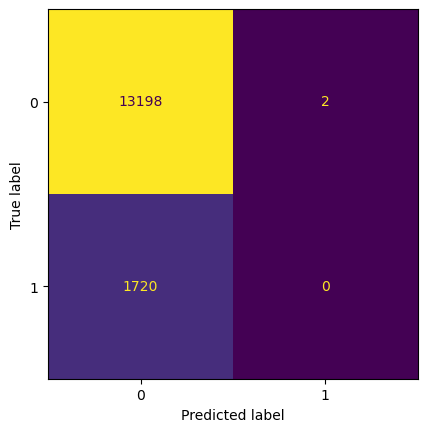

In [209]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
binary_evaluate(y_test, prob_test_logistic, prob = True)

### Feature Importance

In [214]:
def feature_importance_plot(importantces, names):
    # rf2.feature_importances_, index=rf2.feature_names_in_
    _importances = pd.Series(importantces, index=names)
    _indices = np.argsort(importantces)

    fig, ax = plt.subplots()
    _importances[_indices].plot.barh(ax=ax)
    ax.set_title("Feature importances")
    fig.tight_layout()

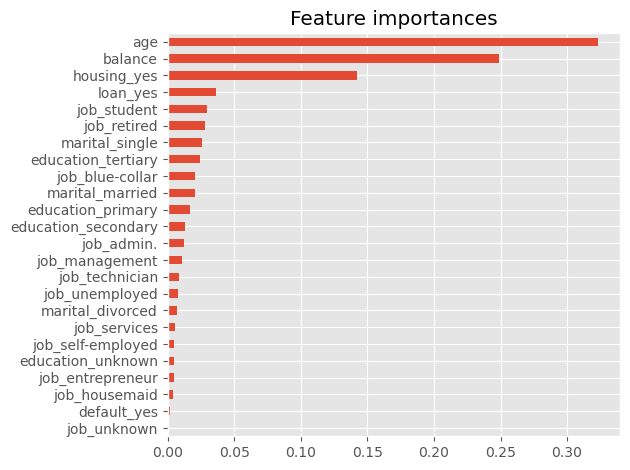

In [215]:
feature_importance_plot(rf2.feature_importances_, rf2.feature_names_in_)

### Partial Dependence

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_partial_dependence_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-partial-dependence-visualization-api-py

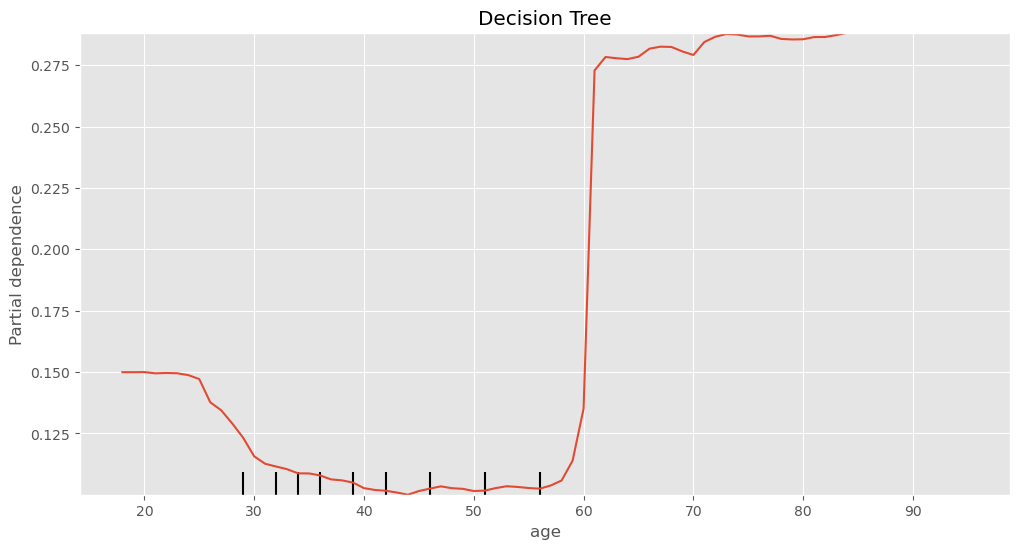

In [152]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree")
PartialDependenceDisplay.from_estimator(rf2, X_train, ["age"], ax=ax)

### Decision Tree Visualization

1. https://mljar.com/blog/visualize-decision-tree/
2. https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

### Calibration Plots

Calibration plot is a visual tool to assess the agreement between predictions and observations in different percentiles (mostly deciles) of the predicted values.

In [2]:
def calibration_plot(y_true, y_pred_score):
    """
    Plot the calibration curve. Assess if the predicted probabiltiy aligns with the true probabilty in bins.
    Only true labels and prediction scores (probabilities) are needed.
    """
    from sklearn.calibration import calibration_curve

    prob_true, prob_pred = calibration_curve(y_true, y_pred_score, n_bins=30)

    fig, ax = plt.subplots(nrows=2, gridspec_kw={"hspace": 0.5})

    # calibration plot
    ax[0].plot(prob_pred, prob_true, "bo-")
    ax[0].plot([0, 0.6], [0, 0.6])
    ax[0].set(
        ylabel="True Probability of Success",
        xlabel="Predicted Probability of Success",
        title="Calibration Curve (based on bins)",
    )
    ax[0].set_xlim(0, 0.6)

    # histogram
    ax[1].hist(y_pred_score, bins=30)
    ax[1].set_xlim(0, 0.6)
    ax[1].set(title="Histogram of estimated probabilities")

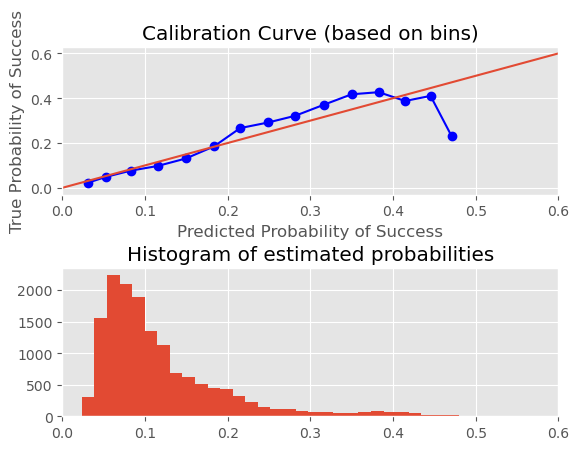

In [216]:
calibration_plot(y_test, prob_test_rf2)

## Tuning the model: Search CV

In [218]:
from sklearn.model_selection import GridSearchCV

In [263]:
xgbr = XGBClassifier(random_state=1, n_estimators=54, use_label_encoder=False, eval_metric="auc")

In [264]:
param_grid1 = {
    "max_depth": [3, 6, 9, 12],
    "min_child_weight": [1, 4, 8],
    "learning_rate": [0.1, 0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(
    estimator=xgbr, param_grid=param_grid1, scoring="roc_auc", cv=5
).fit(X_train, y_train)

In [265]:
# get the best set of parameters from the searching
param2 = grid_search.cv_results_["params"][
    np.argmin(grid_search.cv_results_["rank_test_score"])
]
print(param2)

{'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1}


In [269]:
xgb_grid_best = XGBRegressor(
    random_state=1, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=54
).fit(X_train, y_train)

In [270]:
prob_test_xgb_grid = xgb_model.predict_proba(X_test)[:,1]

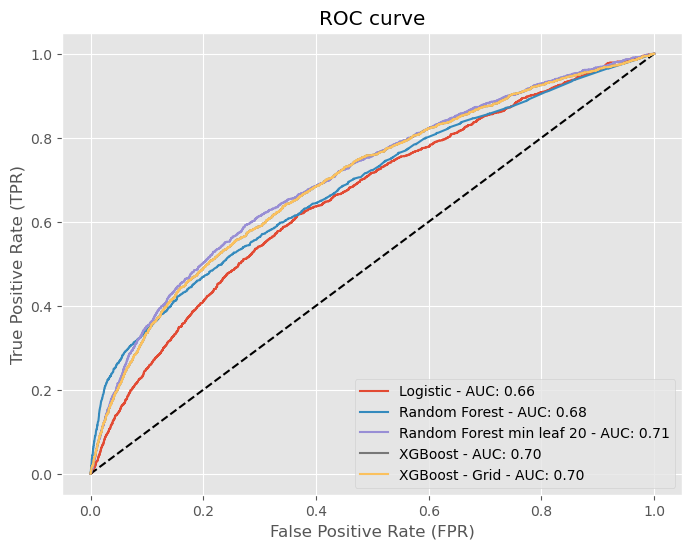

In [271]:
ax = roc_plot(y_test, prob_test_logistic, "Logistic")
roc_plot(y_test, prob_test_rf, "Random Forest", ax)
roc_plot(y_test, prob_test_rf2, "Random Forest min leaf 20", ax)
roc_plot(y_test, prob_test_xgb, "XGBoost", ax)
roc_plot(y_test, prob_test_xgb_grid, "XGBoost - Grid", ax)

### Random Search

In [273]:
from sklearn.model_selection import RandomizedSearchCV

In [282]:
param_grid2 = {
    "max_depth": [3, 6, 9, 12],
    "min_child_weight": [1, 4, 8, 16],
    "eta": [0.05, 0.1, 0.3, 0.5, 0.7],
    "gamma": [0, 10, 100, 1000],
    "subsample": [0.1, 0.3, 0.5, 1],
    "colsample_bylevel": [0.5, 0.7, 1],
    "learning_rate": [0.1, 0.3, 0.5, 0.7],
    "n_estimators": [50, 100, 150]
}

In [283]:
random_grid_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=param_grid2,
    n_iter=16,
    scoring="roc_auc",
    cv=5,
).fit(X_train, y_train)

In [285]:
best_params2 = random_grid_search.cv_results_["params"][
    np.argmin(random_grid_search.cv_results_["rank_test_score"])
]
best_params2

{'subsample': 0.5,
 'n_estimators': 100,
 'min_child_weight': 16,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 10,
 'eta': 0.5,
 'colsample_bylevel': 0.5}

In [286]:
xgb_randCV_best = XGBRegressor(random_state=1, **best_params2).fit(X_train, y_train)

In [287]:
prob_test_xgb_randCV = xgb_model.predict_proba(X_test)[:, 1]

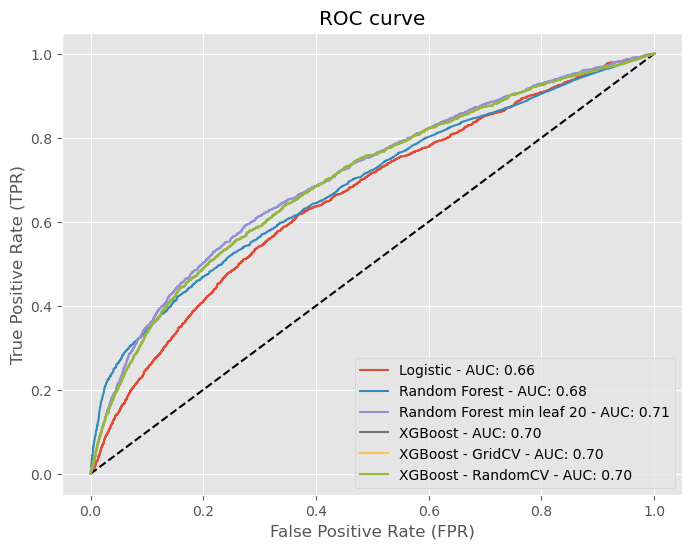

In [288]:
ax = roc_plot(y_test, prob_test_logistic, "Logistic")
roc_plot(y_test, prob_test_rf, "Random Forest", ax)
roc_plot(y_test, prob_test_rf2, "Random Forest min leaf 20", ax)
roc_plot(y_test, prob_test_xgb, "XGBoost", ax)
roc_plot(y_test, prob_test_xgb_grid, "XGBoost - GridCV", ax)
roc_plot(y_test, prob_test_xgb_randCV, "XGBoost - RandomCV", ax)